In [29]:
import numpy as np
from numba import njit, float64, int64
import math
import matplotlib.pyplot as plt 

In [ ]:
@njit(cache=True, fastmath=True)
def compute_hubble(a, H0, Omega_m, Omega_r, Omega_de):
    """Compute Hubble parameter H(a) = H0 * sqrt(Ω_r a⁻⁴ + Ω_m a⁻³ + Ω_de)"""
    a_inv = 1.0 / a
    a_inv2 = a_inv * a_inv
    a_inv3 = a_inv2 * a_inv
    a_inv4 = a_inv3 * a_inv
    
    rad_term = Omega_r * a_inv4
    mat_term = Omega_m * a_inv3
    de_term = Omega_de
    
    return H0 * np.sqrt(rad_term + mat_term + de_term)

@njit(cache=True, fastmath=True)
def compute_f(a, H0, Omega_m, Omega_r, Omega_de):
    """Compute f(a) = H(a) * a"""
    return compute_hubble(a, H0, Omega_m, Omega_r, Omega_de) * a

@njit(cache=True, fastmath=True)
def compute_gamma_ratio(alpha):
    gamma_val = math.gamma(alpha + 1.0)
    gamma_inv = 1.0 / gamma_val
    
    return gamma_val, gamma_inv

In [ ]:
# ============================================================================
# ADAPTIVE TIME STEPPING BASED ON STABILITY ANALYSIS
# ============================================================================

@njit(cache=True, fastmath=True)
def compute_adaptive_time_step(a, alpha, H0, Omega_m, Omega_r, Omega_de,
                               safety=0.1, min_dt=1e-20, max_dt=1.0):
    """
    Compute adaptive time step based on stability analysis:
    Δt = safety × [Γ(α+1) / H(a)]^{1/α}
    
    From paper: Δt ≲ [Γ(α+1) / H(a)]^{1/α}
    """
    
    # Get current Hubble parameter
    H = compute_hubble(a, H0, Omega_m, Omega_r, Omega_de)

    # Get Γ(α+1)
    gamma_val, _ = compute_gamma_ratio(alpha)
    
    # Special case: α = 1
    if alpha == 1.0:
        dt = safety / H
    
    # Special case: α = 0.5 (common in your work)
    elif alpha == 0.5:
        ratio = gamma_val / H
        dt = safety * ratio * ratio  # (ratio)² since 1/α = 2
    
    # General case
    else:
        ratio = gamma_val / H
        if ratio > 0:
            dt = safety * (ratio ** (1.0 / alpha))
        else:
            dt = min_dt
    
    # Era-specific adjustments
    if a < 1e-4:
        # Radiation era: extra conservative
        dt *= 0.3
    elif a < 0.01:
        # Early matter era
        dt *= 0.7
    elif a > 0.5:
        # Dark energy era: can be more aggressive
        dt *= 1.5
    
    # Apply absolute bounds
    if dt < min_dt:
        return min_dt
    elif dt > max_dt:
        return max_dt
    else:
        return dt


In [23]:
# ============================================================================
# WEIGHT COMPUTATION FUNCTIONS
# ============================================================================

@njit(cache=True, fastmath=True)
def compute_single_weight(j, n, alpha, gamma_inv):
    """Compute single weight b_{j,n+1}"""
    term1 = n + 1 - j
    term2 = n - j
    
    # Handle edge cases
    if term1 <= 0:
        weight1 = 0.0
    else:
        weight1 = term1 ** alpha
    
    if term2 <= 0:
        weight2 = 0.0
    else:
        weight2 = term2 ** alpha
    
    return gamma_inv * (weight1 - weight2)

@njit(cache=True, fastmath=True)
def compute_all_weights_vectorized(n, alpha, gamma_inv):
    """
    Compute all weights b_{j,n+1} for j=0..n
    Vectorized for speed
    """
    if n == 0:
        return np.array([gamma_inv], dtype=np.float64)
    
    j = np.arange(0, n + 1)  # j from 0 to n
    
    # Vectorized computation
    term1 = (n + 1 - j).astype(np.float64)
    term2 = (n - j).astype(np.float64)
    
    # Handle negative terms (shouldn't happen but for safety)
    term1 = np.where(term1 > 0, term1, 0.0)
    term2 = np.where(term2 > 0, term2, 0.0)
    
    weights = gamma_inv * (term1 ** alpha - term2 ** alpha)
    
    # Special handling for j=n (should be gamma_inv * (1^α - 0^α))
    weights[-1] = gamma_inv
    
    return weights

In [77]:
# ============================================================================
# MAIN FRACTIONAL FRIEDMANN SOLVER (NO F-STRINGS)
# ============================================================================

@njit(cache=True, fastmath=True)
def solve_fractional_friedmann_full_memory_numba(
    alpha=1.0,
    H0=1.0,
    Omega_m=0.315,
    Omega_r=9.2e-5,
    a_start=1e-6,
    a_end=1.0,
    safety=0.1,
    min_dt_factor=1e-4,
    max_dt_factor=10.0,
    max_iterations=1000000
):

    # Compute dark energy density
    Omega_de = 1.0 - Omega_m - Omega_r
    
    # Get gamma values
    gamma_val, gamma_inv = compute_gamma_ratio(alpha)
    
    # Estimate maximum iterations needed
    estimated_max_steps = min(max_iterations, int(1e6))  # Cap at 1M
    
    # Pre-allocate arrays for full history
    t_full = np.zeros(estimated_max_steps, dtype=np.float64)
    a_full = np.zeros(estimated_max_steps, dtype=np.float64)
    f_full = np.zeros(estimated_max_steps, dtype=np.float64)
    

    # Initial conditions
    t = 0.0
    a = a_start
    
    t_full[0] = t
    a_full[0] = a
    f_full[0] = compute_f(a, H0, Omega_m, Omega_r, Omega_de)
    
    current_size = 1
    
    # Compute initial dt bounds
    H_initial = compute_hubble(a, H0, Omega_m, Omega_r, Omega_de)
    dt_min = min_dt_factor * (gamma_val / H_initial) ** (1.0 / alpha) 
    dt_max = max_dt_factor * (gamma_val / H_initial) ** (1.0 / alpha) 
    
    # Main integration loop
    iteration = 0
    
    while a < a_end and iteration < estimated_max_steps - 1:
        iteration += 1
        
        # Adaptive time step
        dt = compute_adaptive_time_step(
            a, alpha, H0, Omega_m, Omega_r, Omega_de,
            safety, dt_min, dt_max
        )
        
        # Current number of previous points
        n = current_size - 1
        
        # Compute fractional sum Σ_{j=0}^{n} b_{j,n+1} f(a_j)
        if n == 0:
            # First step: simple formula
            sum_term = f_full[0] * gamma_inv
        else:
            # Precompute all weights
            weights = compute_all_weights_vectorized(n, alpha, gamma_inv)
            
            # Get f values (all previous points)
            f_values = f_full[:current_size]
            
            # Dot product (optimized loop)
            sum_term = 0.0
            for j in range(n + 1):
                sum_term += weights[j] * f_values[j]
        
        # Update scale factor: a_{n+1} = a₀ + (Δt)^α × sum_term
        dt_alpha = dt ** alpha
        a_new = a_start + dt_alpha * sum_term
        
        # Update time
        t += dt
        a = a_new
        
        # Store in full history arrays
        if current_size < estimated_max_steps:
            t_full[current_size] = t
            a_full[current_size] = a
            f_full[current_size] = compute_f(a, H0, Omega_m, Omega_r, Omega_de)
            current_size += 1
        else:
            # Arrays full
            break
        
    # Trim arrays to actual size
    t_full = t_full[:current_size]
    a_full = a_full[:current_size]
    f_full = f_full[:current_size]
       
    return t_full, a_full


In [ ]:
t1, a1 = solve_fractional_friedmann_full_memory_numba(
    alpha=1.0,
    H0=1.0,
    Omega_m=0.315,
    Omega_r=9.2e-5,
    a_start=1e-6,
    a_end=1.0,
    safety=0.1,
    min_dt_factor=1e-4,
    max_dt_factor=10.0,
    max_iterations=10000
)

In [79]:
# Convert to physical time (s)
H0_physical = 2.19e-18  # s⁻¹
seconds_per_year = 365.25 * 24 * 3600
seconds_per_Gyr = seconds_per_year * 1e9

# Time from Big Bang in s
t_s = t1 / H0_physical

y_ticks = [1e1,1e3,1e5,1e7,1e9,1e11,1e13,1e15,1e17]

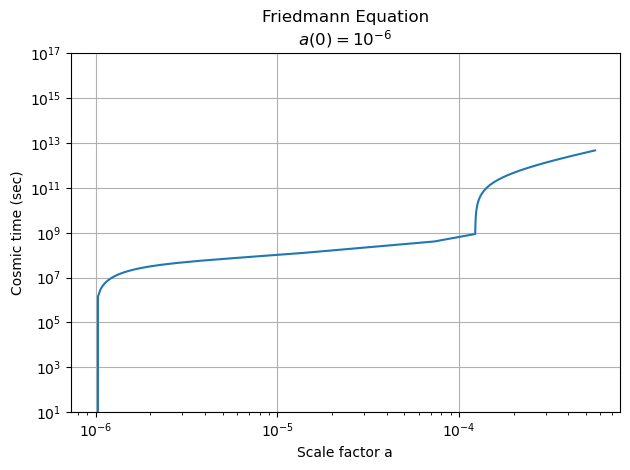

In [80]:
plt.loglog(a1,t_s)
plt.xlabel(r"Scale factor a")
plt.ylabel(r"Cosmic time (sec)")
plt.yticks(y_ticks)
plt.title("Friedmann Equation\n$ a(0)=10^{-6}$")
plt.grid(True)
plt.tight_layout()
plt.show()

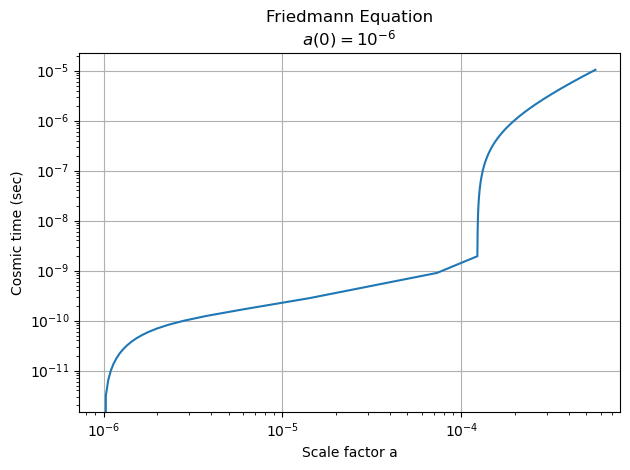

In [71]:
plt.loglog(a1,t1)
plt.xlabel(r"Scale factor a")
plt.ylabel(r"Cosmic time (sec)")
plt.title("Friedmann Equation\n$ a(0)=10^{-6}$")
plt.grid(True)
plt.tight_layout()
plt.show()

In [84]:
t2, a2 = solve_fractional_friedmann_full_memory_numba(
    alpha=1.0,
    H0=1.0,
    Omega_m=0.315,
    Omega_r=0,
    a_start=1e-4,
    a_end=1.0,
    safety=0.1,
    min_dt_factor=1e-4,
    max_dt_factor=10.0,
    max_iterations=10000
)

In [85]:
# Time from Big Bang in s
ts2 = t2 / H0_physical

y_ticks = [1e1,1e3,1e5,1e7,1e9,1e11,1e13,1e15,1e17]

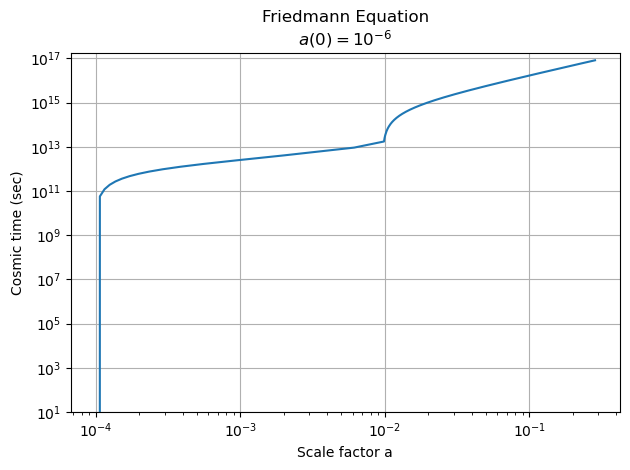

In [86]:
plt.loglog(a2,ts2)
plt.xlabel(r"Scale factor a")
plt.ylabel(r"Cosmic time (sec)")
plt.yticks(y_ticks)
plt.title("Friedmann Equation\n$ a(0)=10^{-6}$")
plt.grid(True)
plt.tight_layout()
plt.show()